# Configurations

In [1]:
dataset_input_dir = "dataset/"
dataset_output_dir = ""
show_parts = True

user_dataset_input = dataset_input_dir + "users-details-2023.csv"                                                                                                                                                                                                   #p@stwi2x
anime_dataset_input = dataset_input_dir + "anime-dataset-2023.csv"
unified_dataset_input = dataset_input_dir + "users-score-2023_short.csv"

anime_dataset_output = dataset_output_dir + "anime_embeddings.csv"
user_dataset_output = dataset_output_dir + "user_embeddings.csv"
# unified_dataset_output = dataset_output_dir + "unified_dataset_prep.csv"

from pyspark.sql import SparkSession
spark = SparkSession\
    .builder \
    .appName("Spark SQL app")\
    .config('spark.eventLog.gcMetrics.youngGenerationGarbageCollectors', 'true')\
    .getOrCreate()

25/04/20 17:33:01 WARN Utils: Your hostname, p4stwi2x resolves to a loopback address: 127.0.1.1; using 192.168.100.188 instead (on interface wlp2s0)
25/04/20 17:33:01 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/20 17:33:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


# Data preprocessing

## How to use

ALWAYS run Related functions before proceeding.

Choose 1 out of the 2 options:
- Hit "Run All" and start from the original datasets (check configs).
- Scroll down to Main Dataset section, there is option to load pre-prepped datasets, run the codes starting from there after configurations.

For easier readability: search "VS code jupyter notebook collapse all".

In order to shorten time, use flag show_parts = True.

NOTE: In my results, the unified dataset contains 23419469 rows x 155 columns, assuming MAX 4 bytes (float) per data, is around 14.5 GB MAX. So make sure you have at least 15 GB if you intend to output the unified dataset.

## Related functions

##### Simple functions

In [2]:
def print_shape(dataFrame):
    print(dataFrame.count(), len(dataFrame.columns))
def unique_categories(dataFrame, colName, show: bool = True):
    L = dataFrame.select(colName).rdd.flatMap(lambda x: x).collect()
    valueSet = {}
    for i in L:
        if i is not None:
            temp = i.split(", ")
            for j in temp:
                if colName + "_" + j not in valueSet.keys():
                    valueSet.update({colName + "_" + j: 1})
                else:
                    valueSet[colName + "_" + j] += 1
    if show:
        print(valueSet)
    return valueSet

##### Dataset column syntax

In [3]:
def fix_syntax(dataFrame):
    # replace ' ' with '_'
    to_change = {}
    column_order = list(dataFrame.columns)
    for i in range(len(column_order)):
        if ' ' in column_order[i]:
            new_name = column_order[i].replace(' ', '_')

            to_change[column_order[i]] = new_name
            column_order[i] = new_name

    dataFrame = dataFrame.withColumnsRenamed(to_change)

    # replace other symbols
    import re
    to_change = {}
    for i in range(len(column_order)):
        new_name = re.sub("[!@#$%^&*().,']","", column_order[i]) 

        if new_name != column_order[i]:
            to_change[column_order[i]] = new_name
            column_order[i] = new_name

    dataFrame = dataFrame.withColumnsRenamed(to_change)

    return dataFrame

##### One-hot encoding

In [4]:
# cre: https://stackoverflow.com/questions/72600575/one-hot-encoding-to-a-list-feature-pyspark
import gc
from pyspark.sql.functions import array_contains, split, col, explode
def oneHotEncoding(dataFrame, colName: str, show: bool = True, support: int = 0):
    size_before = dataFrame.count()

    test_df = dataFrame.select(colName)
    if show:
        print(f"Fill rate: {test_df.filter(col(colName).isNotNull()).count()}/{test_df.count()}")

    # collect list of unique genres
    test_df = test_df.select('*', split(test_df[colName], ',').alias('tags'))
    
    tags = [x[0] 
        for x in 
        test_df.select(explode('tags')).collect()
    ]

    # support check
    tags_count = {}
    for tag in tags:
        if tag not in tags_count.keys():
            tags_count[tag] = 0
        tags_count[tag] += 1

    tag_list = list(tags_count.keys())
    for tag in tag_list:
        if tags_count[tag] < support:
            tags_count.pop(tag, None)

    tags = tags_count.keys() 

    # transfer unique values to panda DF to map the entries
    test_df = test_df.select(colName,
        *[
            array_contains('tags', tag).alias((colName + "_{}").format(tag)).cast("integer")\
            for tag in tags
        ]
    ).dropDuplicates()

    result_df = dataFrame.join(test_df, dataFrame[colName] == test_df[colName], 'left')\
        .drop(colName)

    # store the embedding column list

    return result_df, tags


#### Normalization

Min max

In [5]:
from pyspark.sql.functions import min, max, col
def min_max(dataFrame, colName_in: str, colName_out: str):
    temp_df = dataFrame.select(min(colName_in), max(colName_in)).collect()
    min_val, max_val = float(temp_df[0][0]), float(temp_df[0][1])

    dataFrame = dataFrame.withColumn(colName_out, (col(colName_in)-min_val)/(max_val-min_val))                                                                                                                                                                                         #thien7170

    return dataFrame, list([min_val, max_val])

#### Plot

In [6]:
from pyspark.sql.functions import min, max
import pandas as pd

def plot(dataFrame, colName: str):
    gre_histogram = dataFrame.select(colName).filter(col(colName).cast("float").isNotNull())\
        .rdd.flatMap(lambda x: x)\
        .map(float)\
        .histogram(20)

    pd.DataFrame(
        list(zip(*gre_histogram)), 
        columns=['bin', 'frequency']
    ).set_index('bin').plot(kind='bar')

## User dataset

### Dataset

In [7]:
user_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(user_dataset_input)

user_embed_columns = {}

# element: UNKNOWN
user_df = user_df.replace({'UNKNOWN': None, 'Unknown': None}).dropDuplicates()

if show_parts:
    start_X, start_Y = user_df.count(), len(user_df.columns)
    print_shape(user_df)
    user_df.show(5)

25/04/20 17:33:27 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Young Generation), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
25/04/20 17:33:27 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC, G1 Young Generation), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


731290 16


+------+--------------+------+--------------------+-----------------+--------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+
|Mal ID|      Username|Gender|            Birthday|         Location|              Joined|Days Watched|Mean Score|Watching|Completed|On Hold|Dropped|Plan to Watch|Total Entries|Rewatched|Episodes Watched|
+------+--------------+------+--------------------+-----------------+--------------------+------------+----------+--------+---------+-------+-------+-------------+-------------+---------+----------------+
|   840|Dragon_Empress|Female|1987-07-29T00:00:...|Columbus, Georgia|2006-09-25T00:00:...|       319.5|       7.2|    10.0|   1068.0|   70.0|   69.0|        326.0|       1543.0|     45.0|         19454.0|
|  1620|     Taichi_EX|  Male|1990-02-18T00:00:...|    Washington DC|2007-01-10T00:00:...|       202.1|      7.45|    21.0|    811.0|   69.0|   83.0|        270.0|       1254.0|   

### Data reformatting

In [8]:
print(user_df.columns)

['Mal ID', 'Username', 'Gender', 'Birthday', 'Location', 'Joined', 'Days Watched', 'Mean Score', 'Watching', 'Completed', 'On Hold', 'Dropped', 'Plan to Watch', 'Total Entries', 'Rewatched', 'Episodes Watched']


#### Username

Firstly, we proceed to eliminate column Username as it has nothing to do with analysis.

In [9]:
user_df = user_df.drop('Username')

#### Gender

We use our own function *unique_categories()* to count the non-null unique values.

In [10]:
print(unique_categories(user_df, 'Gender', False))

{'Gender_Female': 96485, 'Gender_Male': 126984, 'Gender_Non-Binary': 914}


As this categorical column has 3 unique values, we perform one-hot encoding with no support.

In [11]:
user_df, col_list = oneHotEncoding(user_df, 'Gender', show=show_parts)
user_embed_columns['Gender'] = col_list

Fill rate: 224383/731290


#### Birthday

In [12]:
user_df.select('Birthday').show(5)

25/04/20 17:35:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/20 17:35:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+--------------------+
|            Birthday|
+--------------------+
|1987-07-29T00:00:...|
|1990-02-18T00:00:...|
|1990-07-24T00:00:...|
|1984-01-08T00:00:...|
|1989-11-25T00:00:...|
+--------------------+
only showing top 5 rows



The values are mostly in the form of "yyyy-mm-ddThh:mm:ss", we shall convert to the unix timestamp. Since the times are very sparse, we shall only take up to days "yyyy-mm-dd".

In [13]:
from pyspark.sql.functions import split, unix_timestamp
split_col = split(user_df['Birthday'], 'T', 2)
user_df = user_df.withColumn('Birthday_d', split_col.getItem(0))\
    .withColumn('Birthday_unix', unix_timestamp('Birthday_d', format='yyyy-mm-dd'))\
    .drop('Birthday', 'Birthday_d')\
    .withColumnRenamed('Birthday_unix', 'Birthday')

In [14]:
if show_parts:
    user_df.select('Birthday').where('Birthday is not NULL').show(5)

+---------+
| Birthday|
+---------+
|538852020|
|632595720|
|633114420|
|442342860|
|601665060|
+---------+
only showing top 5 rows



#### Location

In [15]:
user_df.select('Location').where('Location is not NULL').show()

+--------------------+
|            Location|
+--------------------+
|   Columbus, Georgia|
|       Washington DC|
|              Sweden|
|   Palm Bay, Florida|
|           Singapore|
|       Hyde Park, NY|
|      kadima, Israel|
|           Bucharest|
|   Kuching, Malaysia|
| Palm Coast, Florida|
|      Fort Wayne, IN|
|    Enköping, Sweden|
|         Philippines|
|Zielona Góra, Poland|
|      Athens, Greece|
|       Milano, Italy|
|Mount Forest, Ont...|
|       Gyál, Hungary|
|      Cracow, Poland|
|       Reims, France|
+--------------------+
only showing top 20 rows



As you can see, the location format is very inconsistent, going back and forth between cities and/or countries and imcomprehensible values. 

It is better for us to drop this column for now.

In [16]:
user_df = user_df.drop('Location')

#### Joined

This is the date when the user joins the MyAnimeList platform. 

If we intend to use this data to check user's anime-watching duration to give more weights to those who watch more and are able to rate titles more objectively, it shall be better to use the column "Days Watched" instead.

Hence, this column is dropped.

In [17]:
user_df = user_df.drop('Joined')

#### Days Watched

This column shows the number of days user has spent watching anime. The more experience one has with watching, one could judge and rate anime titles more accurately.

Hence, we use this column, with the name changed for easier SQL queries.

In [18]:
user_df = user_df.withColumnRenamed('Days Watched', 'Days_Watched')

The more time one spends watching anime, the more they can observe and rate anime titles more correctly. And the difference between experienced watchers (such as 1000 and 2000 hours) is not as much as between inexperienced (10 hours) and experienced (500 hours).

We shall perform log transformation then standardization and do not perform any outlier elimination.

In [19]:
# from pyspark.sql.functions import log10, col
# user_df = user_df.withColumn('Days_Watched_log', log10(col('Days_Watched')+1.0))
# user_df = user_df.drop('Days_Watched')\
# .withColumnRenamed('Days_Watched_log', 'Days_Watched')

# user_df, user_embed_columns['Days_Watched'] = min_max(user_df, 'Days_Watched', 'A1')
# user_df = user_df.drop('Days_Watched').withColumnRenamed('A1', 'Days_Watched')

# if show_parts:
#     user_df.select('Days_Watched').show(5)

In [20]:
if show_parts:
    print_shape(user_df)

25/04/20 17:35:46 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


731290 15


#### Watching, On Hold, Dropped, Plan to Watch, Total Entries

These columns are to see how the user interacts with anime titles.

But since the Total Entries is technically the sum of other 4 columns, it's better we eliminate this only.

In [21]:
user_df = user_df.drop('Total Entries')

#### Completed, Rewatched, Episodes Watched

These columns are important in determining user's experience in watching anime, similar to Days Watched. However, since Rewatched only counts number of titles a user has rewatched, without pointing out which titles exactly, and furthermore is similar to, and counted within, the Episodes Watched column.

Our decision is to drop Rewatched, and keep the other two, like Days Watched: log transformation.

In [22]:
# user_df = user_df.drop('Rewatched')\
#     .withColumnRenamed('Episodes Watched', 'Episodes_Watched')

# a, b = 'Episodes_Watched', 'Completed'

# user_df = user_df.withColumn(a + '_l', log10(col(a)+1.0))\
#     .withColumn(b+ '_l', log10(col(b)+1.0))\
#     .drop(a, b)\
#     .withColumnRenamed(a+'_l', a)\
#     .withColumnRenamed(b+'_l', b)

# user_df, user_embed_columns[b] = min_max(user_df, b, b+'_m')
# user_df, user_embed_columns[a] = min_max(user_df, a, a+'_m')
# user_df = user_df.drop(a,b)\
#     .withColumnRenamed(a+'_m', a)\
#     .withColumnRenamed(b+'_m', b)

# if show_parts:
#     user_df.select(a,b).show(5)

In [23]:
if show_parts:
    print_shape(user_df)

25/04/20 17:36:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/20 17:36:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


731290 14


#### Results

After data formatting, this is what we got.

In [24]:
if show_parts:
    user_df.show(5)

25/04/20 17:36:14 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+------+------------+----------+--------+---------+-------+-------+-------------+---------+----------------+-------------+-----------+-----------------+---------+
|Mal ID|Days_Watched|Mean Score|Watching|Completed|On Hold|Dropped|Plan to Watch|Rewatched|Episodes Watched|Gender_Female|Gender_Male|Gender_Non-Binary| Birthday|
+------+------------+----------+--------+---------+-------+-------+-------------+---------+----------------+-------------+-----------+-----------------+---------+
|   840|       319.5|       7.2|    10.0|   1068.0|   70.0|   69.0|        326.0|     45.0|         19454.0|            1|          0|                0|538852020|
|  1620|       202.1|      7.45|    21.0|    811.0|   69.0|   83.0|        270.0|      0.0|         11604.0|            0|          1|                0|632595720|
|  2311|        14.1|      8.28|     9.0|     15.0|    0.0|    2.0|          1.0|      2.0|           848.0|            0|          1|                0|633114420|
|  2479|        26.4| 

### Data preprocessing

#### Correlation

Firstly, we analyze the correlations between the columns.

25/04/20 17:37:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/20 17:37:42 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


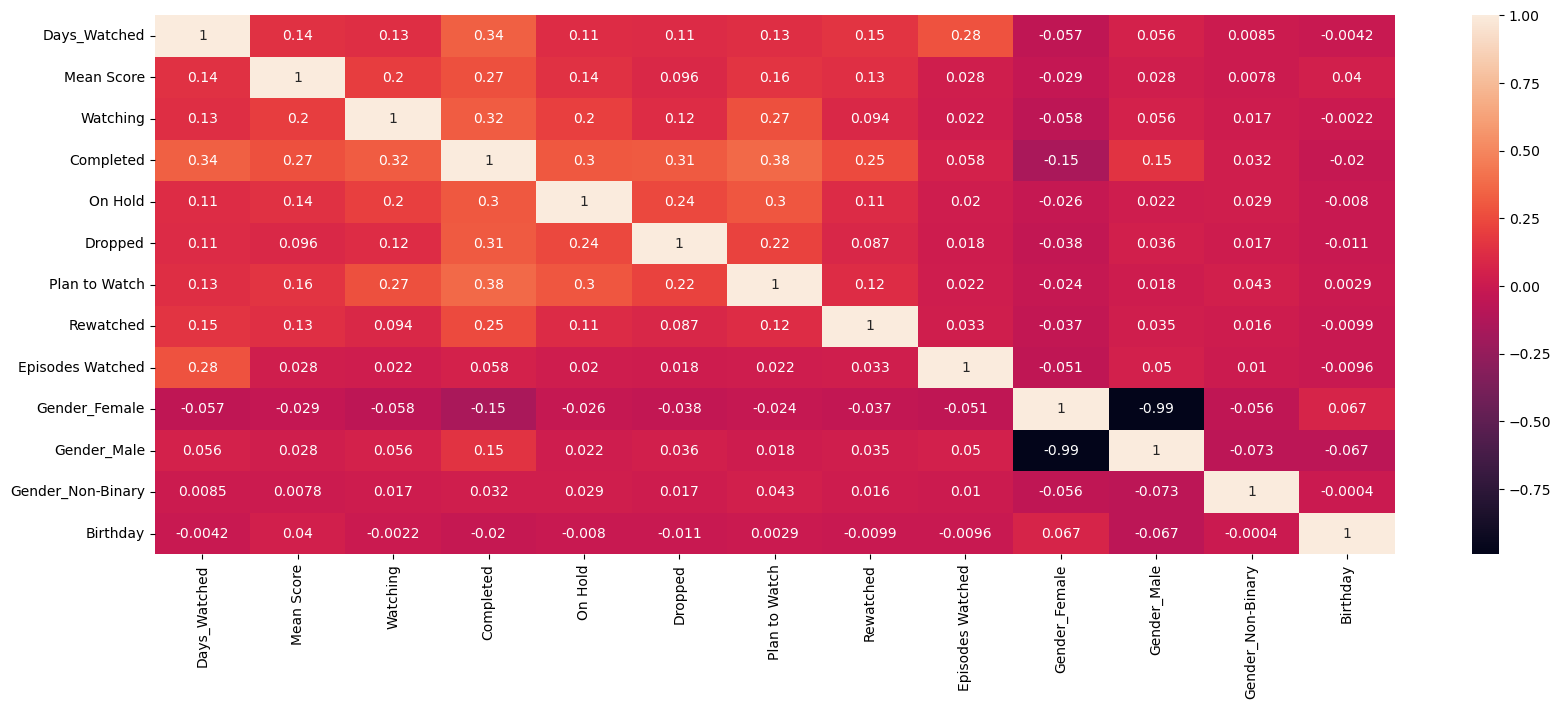

In [26]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

sns.heatmap(user_df.drop('Mal ID').toPandas().corr(), annot=True)
plt.rcParams['figure.figsize'] = (20, 8)
plt.show()


Our observation:
1. We can clearly see that how Completed has so much correlation, and is somewhat a simpler representative of its surrounding columns: Watching, On Hold, Dropped, Plan to Watch. Similarly, we have Days Watched. **Conclusion: drop Completed & Days_Watched.**
2. On Hold, Dropped, Plan to Watch: similar to each other and have similar patterns on other columns, except that Dropped is always lower than the other two. **Conclusion: we combine the 3 columns into 1, where we increase the weight of Dropped in contrast to the others.**
3. Episodes Watched has interestingly low correlation to other columns compared to our original expectations.

In [30]:
user_df = user_df.drop('Completed', 'Days_Watched')
user_df = user_df.withColumn(colName='watch1', col=col('On Hold')*0.25 + col('Plan to Watch')*0.25 + col('Dropped')*0.5)\
        .drop('On Hold', 'Plan to Watch', 'Dropped')

New observation

25/04/20 19:00:07 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/20 19:00:08 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


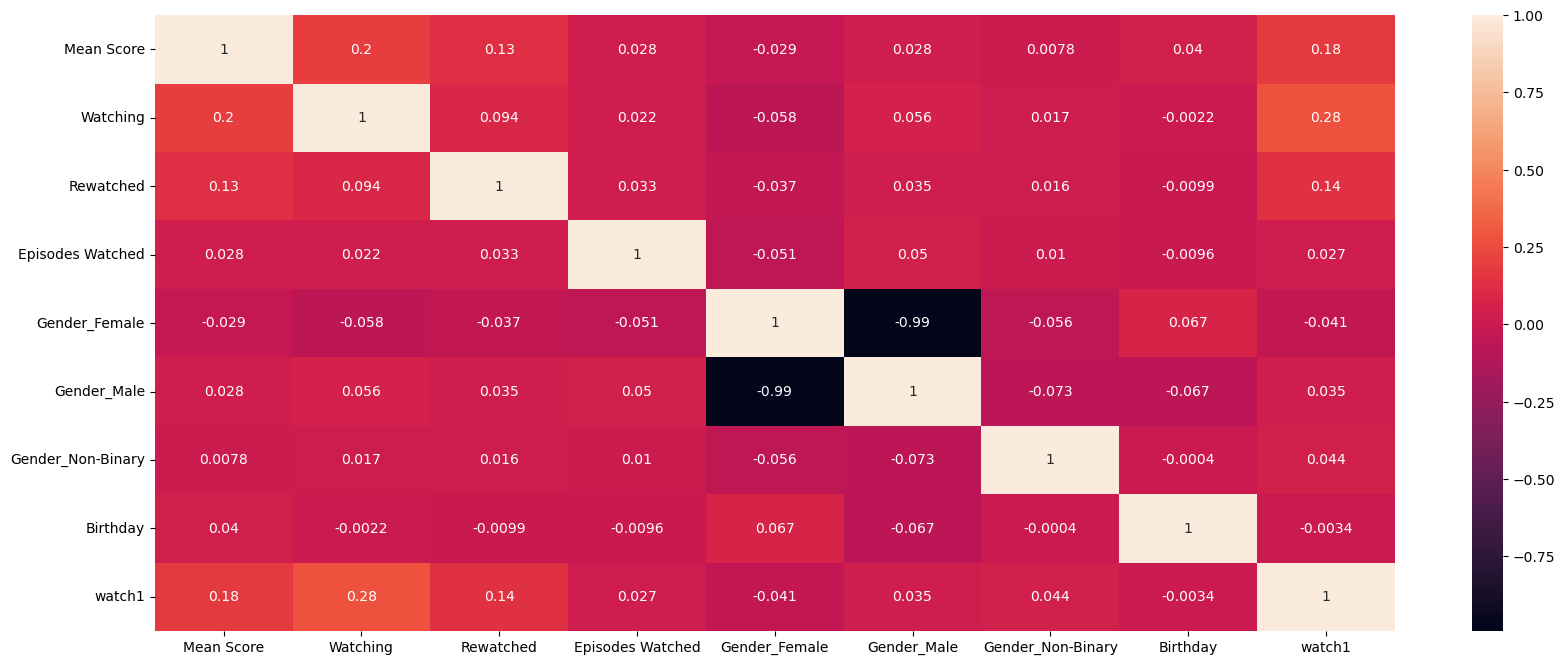

In [32]:
sns.heatmap(user_df.drop('Mal ID').toPandas().corr(), annot=True)
plt.rcParams['figure.figsize'] = (20, 8)
plt.show()

We can still see correlation between Mean Score, Watching, Rewatched and watch1. But we shall not touch them as the correlations between them and other columns are not similar.

#### Normalization

In [46]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

user_df.drop('Mal ID').to_pandas_on_spark().boxplot()

/home/p4stwi2x/anaconda3/lib/python3.12/site-packages/pyspark/sql/dataframe.py:5725: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(
/home/p4stwi2x/anaconda3/lib/python3.12/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(
25/04/20 19:22:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/20 19:22:25 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/20 19:23:01 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/04/20 19:23:01 WARN RowBasedKeyValueBatch: Calling spill(

25/04/20 21:28:19 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 1192107 ms exceeds timeout 120000 ms
25/04/20 21:28:23 WARN SparkContext: Killing executors is not supported by current scheduler.
25/04/20 21:28:24 WARN NettyRpcEnv: Ignored failure: java.util.concurrent.TimeoutException: Cannot receive any reply from p4stwi2x.lan:42753 in 10000 milliseconds
25/04/20 21:28:24 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.rpc.RpcTimeoutException: Futures timed out after [10000 milliseconds]. This timeout is controlled by spark.executor.heartbeatInterval
	at org.apache.spark.rpc.RpcTimeout.org$apache$spark$rpc$RpcTimeout$$createRpcTimeoutException(RpcTimeout.scala:47)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:62)
	at org.apache.spark.rpc.RpcTimeout$$anonfun$addMessageIfTimeout$1.applyOrElse(RpcTimeout.scala:58)
	at scala.runtime.AbstractPartialFunction.apply(AbstractPartialFu

### Saving data

User embeddings dataset

In [32]:
user_df.coalesce(1).write\
        .option("header", "true")\
        .option("sep", ",")\
        .mode("overwrite")\
        .csv(user_dataset_output)

25/04/05 20:40:34 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


Embedded columns

In [ ]:
# import json

# with open('user_embed_col.json', 'w') as fp:
#     json.dump(user_embed_columns, fp, indent=4)

## Anime dataset

### Dataset

In [33]:
anime_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(anime_dataset_input)

anime_embed_columns = {}

# element: UNKNOWN
anime_df = anime_df.replace({'UNKNOWN': None, 'Unknown': None})
anime_df.dropDuplicates()

# change column names for better SQL
anime_df = anime_df.withColumnRenamed('Scored By', 'Scored_By')

if show_parts:
    start_X, start_Y = anime_df.count(), len(anime_df.columns)
    print_shape(anime_df)
    anime_df.show(20)

In [34]:
# check sparsity for each column
from pyspark.sql.functions import col
from collections import OrderedDict

if show_parts:
    rows = anime_df.count()
    sparsity_score = [anime_df.filter(col(Col).isNotNull()).count() / rows for Col in anime_df.columns]

    sparsity_list = OrderedDict()
    for i in range(len(anime_df.columns)):
        sparsity_list[anime_df.columns[i]] = sparsity_score[i]
    #spark.createDataFrame([d_list]).show()
    sparsity_list.items()

### Data preprocessing

#### Name, English name, Other name (finished)

Since the problem is about recommendation based on user's taste, it is expected that these features have nothing to do with our recommendation system.

In [35]:
anime_df = anime_df.drop("Name", "English name", "Other name")
if show_parts:
    anime_df.show()

In [36]:
print_shape(anime_df)

24905 21


#### Score (finished)

As this is a numerical column, we perform data normalization.

In [37]:
anime_df, anime_embed_columns['Score'] = min_max(anime_df, "Score", "Score_s")

anime_df = anime_df.drop('Score').withColumnRenamed(existing="Score_s",new="Score")

if show_parts:
    plot(anime_df, "Score")

In [38]:
if show_parts:
    anime_df.select("Score").show()

In [39]:
from pyspark.sql.functions import median, mode
if show_parts:
    anime_df.select(median("Score"), mode("Score")).show()

Even though the data is negatively skewed (mean = 0, median = 0.009, mode = 0.171), the skewed-ness is insignificant and can be allowed for analysis.

In [40]:
if show_parts:
    print_shape(anime_df)

#### Genres (finished)

Since the column is categorical and the label order in Genres is not important, we use one-hot encoding.

In [41]:
anime_df, col_list = oneHotEncoding(anime_df, "Genres", show=show_parts)
anime_embed_columns['Genres'] = col_list

In [42]:
if show_parts:
    print_shape(anime_df)

#### Synopsis (finished)

Synopsis is description of an anime title and has quite some impact to user's taste. However we temporarily leave this out for simplicity.

In [43]:
anime_df = anime_df.drop("Synopsis")

#### Type (finished)

Similar to Genres, we use one-hot encoding here.

In [44]:
if show_parts:
    anime_df.select("Type").groupBy("Type").count().show()

Since only 0.3% of samples have empty values, so we should have no problem dropping these rows.

In [45]:
anime_df = anime_df.filter("Type is not NULL")
anime_df.select("Type").groupBy("Type").count().show()

25/04/05 20:40:56 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+-----+
|   Type|count|
+-------+-----+
|     TV| 7597|
|Special| 2558|
|    OVA| 4076|
|  Music| 2686|
|  Movie| 4381|
|    ONA| 3533|
+-------+-----+



Then we perform one-hot encoding

In [46]:
anime_df, col_list = oneHotEncoding(anime_df, "Type")
user_embed_columns['Type'] = col_list

Fill rate: 24831/24831


In [47]:
print_shape(anime_df)

24831 65


#### Episodes (finished)

Anime length (no. of episodes and duration) might have to do with watching trends.

In [48]:
anime_df, anime_embed_columns['Episodes'] = min_max(anime_df, "Episodes", "A1")
anime_df = anime_df.drop('Episodes').withColumnRenamed("A1", "Episodes")

#### Aired (finished)

The format is in the form of "(start date) to (end date)", so we perform splitting into two columns.

In [49]:
# column: Aired 
from pyspark.sql.functions import split, to_date

split_col = split(anime_df["Aired"], " to ", 2)
anime_df = anime_df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
anime_df = anime_df.withColumn("air_start", to_date(col("F1"), "MMM d, yyyy"))\
    .withColumn("air_end", to_date(col("F2"), "MMM d, yyyy"))\
    .drop("F1", "F2", "Aired")
if show_parts:
    anime_df.select("air_start", "air_end").show()

In some cases, some titles do not have both timestamps.

In [50]:
if show_parts:
    print(anime_df.select("air_start", "air_end").where("air_start is not NULL").count())
    print(anime_df.select("air_start", "air_end").where("air_end is not NULL").count())
    print(anime_df.select("air_start", "air_end").where("air_start is not NULL AND air_end is not NULL").count())                                                               #p4stwi2x
    print(anime_df.count())

Since the number of missing values is huge for both columns and users can manually filter the recommendation rankings, our choice is to drop the columns in processing.

In [51]:
anime_df = anime_df.drop("air_start", "air_end")
if show_parts:
    anime_df.show()

#### Premiered (finished)

Since some users might have the tendency to watch the latest titles, and so as some for the older titles for nostalgia, trendy eras, etc., we shall use this feature. The feature is in the form of season and year, which we shall transform into real numbers.

In [52]:
from pyspark.sql.functions import split, col

if show_parts:
    print(f"Column sparsity: {sparsity_list["Premiered"]}")

split_col = split(anime_df["Premiered"], " ", 2)
anime_df = anime_df.withColumn("F1", split_col.getItem(0)).withColumn("F2", split_col.getItem(1))
anime_df = anime_df.na.replace(['spring', 'summer', 'fall', 'winter'], ['0', '0.25', '0.5', '0.75'], 'F1')\
    .withColumn("Premiered_f", col('F1')+col('F2')).drop("Premiered", "F1", "F2")

if show_parts:
    plot(anime_df, "Premiered_f")

In [53]:
from pyspark.sql.functions import mean, median, mode
anime_df, anime_embed_columns['Premiered'] = min_max(anime_df, "Premiered_f", "Premiered_fo")

if show_parts:
    anime_df.select(median("Premiered_fo"), mode("Premiered_fo")).show()

anime_df = anime_df.drop("Premiered", "Premiered_f").withColumnRenamed(existing="Premiered_fo", new="Premiered")
if show_parts:
    plot(anime_df, "Premiered")

#### Status (finished)

List of unique values:

In [54]:
unique_categories(anime_df, "Status", show=show_parts)

{'Status_Finished Airing': 24063,
 'Status_Currently Airing': 347,
 'Status_Not yet aired': 421}

Since the list is short, we shall perform one-hot encoding with no support without any issue.

In [55]:
anime_df, col_list = oneHotEncoding(anime_df, "Status", show=show_parts)
anime_embed_columns['Status'] = col_list
if show_parts:
    anime_df.show()

#### Producers (finished)

In [56]:
uVal = unique_categories(anime_df, "Producers", show=show_parts)
if show_parts:
    print(uVal)

Too many columns so we have to add support. Firstly we have to plot the frequencies of the categories.

In [57]:
if show_parts:
    uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
    plot(uVal_df, "col1")
    plot(uVal_df.where("col1 > 60"), "col1")

In [58]:
if show_parts:
    print(uVal_df.count())
    print(uVal_df.where("col1 >= 100").count())
    print(uVal_df.where("col1 >= 150").count())
    print(uVal_df.where("col1 >= 200").count())

So we shall get support = 100 for 56 entries, in order to avoid having too much features causing overfitting.

In [59]:
anime_df, col_list = oneHotEncoding(anime_df, "Producers", show=show_parts, support=100)
anime_embed_columns['Producers'] = col_list
if show_parts:
    anime_df.show()

#### Licensors (finished)

In [60]:
if show_parts:
    uVal = unique_categories(anime_df, "Licensors", show=show_parts)
    print(len(uVal))

In [61]:
if show_parts:
    uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
    plot(uVal_df, "col1")
    plot(uVal_df.where("col1 < 65"), "col1")

In [62]:
if show_parts:
    print(uVal_df.count())
    print(uVal_df.where("col1 >= 30").count())
    print(uVal_df.where("col1 >= 50").count())
    print(uVal_df.where("col1 >= 100").count())

In [63]:
anime_df, col_list = oneHotEncoding(anime_df, "Licensors", show=show_parts, support=100)
anime_embed_columns['Licensors'] = col_list
if show_parts:
    anime_df.show()

#### Studios (finished)

In [64]:
if show_parts:
    uVal = unique_categories(anime_df, "Studios", False)
    print(len(uVal))

In [65]:
if show_parts:
    uVal_df = spark.createDataFrame(pd.DataFrame(list(uVal.values()), columns=['col1']))
    plot(uVal_df, "col1")
    plot(uVal_df.where("col1 > 100"), "col1")

In [66]:
if show_parts:
    print(uVal_df.count())
    print(uVal_df.where("col1 >= 100").count())
    print(uVal_df.where("col1 >= 150").count())

In [67]:
anime_df, anime_embed_columns['Studios'] = oneHotEncoding(anime_df, "Studios", show=show_parts, support=100)
if show_parts:
    anime_df.show()

#### Source (finished)

In [68]:
if show_parts:
    uVal = unique_categories(anime_df, "Source", False)
    print(len(uVal))

The number of categories is small, so we do not reduce.

In [69]:
anime_df, col_list = oneHotEncoding(anime_df, "Source", show=show_parts, support=100)
anime_embed_columns['Source'] = col_list
if show_parts:
    anime_df.show()

#### Duration (finished)

The format is "? hr ? min (per ep)", we shall convert to a single number representing the duration for each episode in minutes.

In [70]:
import pandas as pd

temp_df = anime_df.select("Duration")
#temp_df.show()

data = temp_df.toPandas()["Duration"].tolist()
new_d = []
for i in range(len(data)):
    if data[i] is not None:
        S = data[i].split(" per ep")[0]
        if "min" not in S:
            if "hr" in S:
                S += " 0 min"
            else:
                S = "0 min " + S
        if "hr" not in S:
            S = "0 hr " + S
        if "sec" not in S:
            S += " 0 sec"
        
        h, m, s = S.split(" hr ")[0], S.split(" hr ")[1].split(" min ")[0], S.split(" hr ")[1].split(" min ")[1].split(" sec")[0]
        new_d.append(int(h)*3600+int(m)*60+int(s))
    else:
        new_d.append(None)
if show_parts:
    print(len(new_d))
data = spark.createDataFrame(pd.DataFrame({
    'Duration': data,
    'Duration_f': new_d
})).dropDuplicates()

anime_df = anime_df.join(data, 'Duration', 'left').drop("Duration").withColumnRenamed(existing="Duration_f", new="Duration").dropDuplicates()                   #p4stwi2x
if show_parts:
    anime_df.show()

In [71]:
if show_parts:
    anime_df.count()

#### Rating (finished)

This feature shall be used to filter the recommendation list by user's age and/or filter options, hence it is not to be in the processing.

In [72]:
anime_df = anime_df.drop("Rating")

#### Rank (finished)

From the author: "The rank of the anime based on popularity or other criteria". Since the metric is not clear and we are here to predict the ranking by ourselves, so it is better to have this feature removed.

In [73]:
anime_df = anime_df.drop("Rank")

#### Popularity (finished)

From the author: "The popularity rank of the anime". It is indeed that the more popular titles are likely to be watched by users, so they should appear higher on our predicted ranking list.

In [74]:
if show_parts:
    plot(anime_df, "Popularity")

However, it is indeed that this column is just the ranking for the titles, which do not have much value in determining the actual differences between the popularity of two different anime titles. So it is better for us to drop this and come up with a different way to get the popularity.

In [75]:
anime_df = anime_df.drop("Popularity")

#### Favorites, Scored By, Members (finished)

As we mentioned with the Popularity column, we shall find ways to represent an anime title's popularity. That is why we keep these 3 features, using log normalization.

In [76]:
for i in ['Favorites', 'Scored_By', 'Members']:
    anime_df = anime_df.withColumn(i+'_l', log10(col(i)+1.0))\
        .drop(i).withColumnRenamed(existing=i+'_l', new=i)             

This feature suggests the number of times an anime title is scored. As explained from the Popularity feature, this shall determine how popular a title is to be better on our ranking list.

#### Image URL (finished)

The feature has nothing to do with data processing, so the column is expected to be removed.

In [77]:
anime_df = anime_df.drop("Image URL")

### Saving data

Preprocessed data

In [81]:
anime_df.coalesce(1).write\
        .option("header", "true")\
        .option("sep", ",")\
        .mode("overwrite")\
        .csv(anime_dataset_output)

Embedded columns list

In [82]:
# import json

# with open('anime_embed_col.json', 'w') as fp:
#     json.dump(anime_embed_columns, fp, indent=4)

## Main dataset

#### Optional: Read pre-prepped side datasets

Note: 
- Ctrl+A to choose all code lines.
- Ctrl+K then Ctrl+C to comment all lines selected.
- Ctrl+K then Ctrl+U to uncomment all lines selected.
- Change the csv paths ONLY.

In [7]:
anime_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv("anime_embeddings.csv")
user_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv("user_embeddings.csv")

25/04/06 13:08:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC, G1 Young Generation), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors
25/04/06 13:08:19 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Young Generation), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Vectorization of user and anime embeddings

In [8]:
from pyspark.sql.functions import array, col
user_embeddings = user_df.select('Mal ID', array([col(column) for column in user_df.columns if column != 'Mal ID']).alias('user_encoded'))
user_embeddings_size = len(user_df.columns) - 1

anime_embeddings = anime_df.select('anime_id', array([col(column) for column in anime_df.columns if column != 'anime_id'])\
    .alias('anime_encoded'))
anime_embeddings_size = len(anime_df.columns) - 1
if show_parts:
    user_embeddings.show(5,False)
    anime_embeddings.show(5,False)

#### Read main dataset

In [9]:
rating_df = spark.read\
    .option("header", True)\
    .option("escape", '"')\
    .option("multiline", True)\
    .option("sep", ",")\
    .csv(unified_dataset_input)

rating_df.dropDuplicates()

if show_parts:
    start_X, start_Y = rating_df.count(), len(rating_df.columns)
    print_shape(rating_df)
    #main_df.show(20) #This takes a while so by default is commented out.

num_users = rating_df.select('user_id').distinct().count()
num_animes = rating_df.select('anime_id').distinct().count()

Dataset limitation for testing purpose.

In [10]:
# rating_df.limit(10000).coalesce(1).write\
#         .option("header", "true")\
#         .option("sep", ",")\
#         .mode("overwrite")\
#         .csv(unified_dataset_output)

In [11]:
from pyspark.sql.functions import col
from collections import OrderedDict

if show_parts:
    rows = rating_df.count()
    sparsity_score = [rating_df.filter(col(Col).isNotNull()).count() / rows for Col in rating_df.columns]

    sparsity_list = OrderedDict()
    for i in range(len(rating_df.columns)):
        sparsity_list[rating_df.columns[i]] = sparsity_score[i]
    print(sparsity_list.items())

#### Columns: Username, Anime Title

Since we already have the two ID columns, we shall remove these string columns to make the dataset far lighter.

In [12]:
rating_df = rating_df.drop('Username', 'Anime Title')

if show_parts:
    print_shape(rating_df)

#### Datasets: Join

We perform joining the embedding datasets into one unified dataset.

In [13]:
main_df = rating_df\
    .join(user_embeddings, rating_df['user_id'] == user_embeddings['Mal ID'], 'left')\
    .join(anime_embeddings, rating_df['anime_id'] == anime_embeddings['anime_id'], 'left')

main_df = main_df.drop(user_embeddings['Mal ID'], anime_embeddings['anime_id'])
if show_parts:
    print_shape(main_df)

#### Saving columns (used for future embeddings)

In [14]:
# import json

# with open('unified_embed_col.json', 'w') as fp:
#     json.dump(dict({'unified_embed': list(main_df.columns)}), fp, indent=4)

#### Saving short version of data

Note: 
- Ctrl+A to choose all code lines.
- Ctrl+K then Ctrl+C to comment all lines selected.
- Ctrl+K then Ctrl+U to uncomment all lines selected.

In [15]:
# temp_df = main_df.limit(10000)
# temp_df.coalesce(1).write\
#         .option("header", "true")\
#         .option("sep", ",")\
#         .mode("overwrite")\
#         .csv(unified_dataset_output)

#### Saving full data (very, very long > 8 mins)

Note: 
- Ctrl+A to choose all code lines.
- Ctrl+K then Ctrl+C to comment all lines selected.
- Ctrl+K then Ctrl+U to uncomment all lines selected.

In [16]:
# main_df.coalesce(1).write\
#         .option("header", "true")\
#         .option("sep", ",")\
#         .mode("overwrite")\
#         .csv(unified_dataset_output)

## Final results

In [ ]:
if show_parts:
    print_shape(main_df)
    main_df.show()

# Train

## Dataset split

In [17]:
main_df = main_df.limit(10000)
num_users = main_df.select("user_id").distinct().count()
num_animes = main_df.select('anime_id').distinct().count()

Dataset split train + test.

In [18]:
from pyspark.sql.functions import rand
def randomize_and_split(df, test_size=0.2, seed=100):

    df_shuffled = df.orderBy(rand(seed=seed)).cache()

    train_df, test_df = df_shuffled.randomSplit([1 - test_size, test_size], seed=seed)
    print("Number of samples in the training set:", train_df.count())
    print("Number of samples in the test set:", test_df.count())
    return train_df, test_df

train_df, test_df = randomize_and_split(main_df, 0.2, 100)

25/04/06 13:08:38 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


Number of samples in the training set: 8034
Number of samples in the test set: 1966


Dataset split X (attributes) + Y (rating)

In [19]:
print(main_df.columns)

['user_id', 'anime_id', 'rating', 'user_encoded', 'anime_encoded']


In [20]:
import numpy as np

def check_validity(df_collect):
    for i in range(len(df_collect)):
        if isinstance(df_collect[i], list):
            for j in range(len(df_collect[i])):
                if df_collect[i][j] is None:
                    pass
                elif float(df_collect[i][j]) >= 0 and float(df_collect[i][j]) <= 1:
                    pass
                else:
                    raise ValueError("check_validity")

def extract_embedding(df, colName, vectorSize):
    train = df.select('user_encoded').rdd.flatMap(lambda x: x).collect()
    #check_validity(train)
    # note: since some rows are fully NULL, replaced by a NULL vector
    for i in range(len(train)):
        if train[i] is None:
            train[i] = [None] * vectorSize
        elif not isinstance(train[i], list):
            train[i] = list(train[i])
        if len(train[i]) < vectorSize:
            train[i] += [None] * (vectorSize - len(train[i]))

    train = np.array(train)

    # convert float
    nan = np.empty_like(train).flatten()
    for i, x in enumerate(train.flat):
        try:
            nan[i] = float(x)
        except:
            nan[i] = 0
    train = np.array(nan, dtype=np.float32).reshape(train.shape)

    return train

def prepare_spark_data(df):
    # Collect data as separate arrays
    # user_data = np.array(df.select("user_encoded").rdd.flatMap(lambda x: x).collect(), dtype=np.int64)
    # anime_data = np.array(df.select("anime_encoded").rdd.flatMap(lambda x: x).collect(), dtype=np.int64)
    # ratings = np.array(df.select("scaled_rating").rdd.flatMap(lambda x: x).collect(), dtype=np.float32)

    ratings = np.array(df.select('rating').rdd.flatMap(lambda x: x).collect(), dtype=np.float32)

    # credit: https://stackoverflow.com/a/68907592
    user_train = extract_embedding(df, 'user_encoded', len(user_df.columns)-1)
    anime_train = extract_embedding(df, 'anime_encoded', len(anime_df.columns)-1)

    print(len(user_train), len(user_train[0]), len(anime_train), len(anime_train[0]))
    
    # return [user_data, anime_data], ratings
    return [user_train, anime_train], ratings

# Prepare data
X_train, y_train = prepare_spark_data(train_df)
X_test, y_test = prepare_spark_data(test_df)

8034 8 8034 152
1966 8 1966 152


## Model

#### Set up model

In [21]:
import keras

## Import necessary modules for collaborative filtering
from keras.layers import Input, Embedding, Dot, Flatten, Dense
from keras.models import Model
from keras.optimizers import Adam

def RecommenderNet(num_users, num_animes, embedding_size=128):
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[user_embeddings_size,])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)

    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[anime_embeddings_size,])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)

    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)

    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)

    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=["mae", "mse"])

    return model

print(num_users)
print(num_animes)
print(user_embeddings_size, anime_embeddings_size)
model = RecommenderNet(num_users, num_animes)

# Printing my model summary
model.summary()

2025-04-06 13:09:01.111711: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.


74
2603
8 152


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_encoded        │ (None, 8)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_encoded       │ (None, 152)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 8, 128)    │      9,472 │ user_encoded[0][… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 152, 128)  │    333,184 │ anime_encoded[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 8, 152)    │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1216)      │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │     77,888 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 420,609 (1.60 MB)

 Trainable params: 420,609 (1.60 MB)

 Non-trainable params: 0 (0.00 B)

#### Model configs

##### Parameters

In [22]:
# Define the initial learning rate, minimum learning rate, maximum learning rate, and batch size
start_lr = 0.01
min_lr = 0.01
max_lr = 0.5
batch_size = 1000

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

##### Configurations setup

In [23]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = 'myanime.weights.h5'

# Model checkpoint callback to save the best weights
model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                    save_weights_only=True,
                                    monitor='val_loss',
                                    mode='min',
                                    save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoints,
    lr_callback,
    early_stopping
]

##### Execute

In [24]:
# Model training
import tensorflow as tf
tf.config.run_functions_eagerly(True)

history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=50,
    verbose=2,
    validation_data=(X_test, y_test),
    callbacks=my_callbacks
)

model.load_weights(checkpoint_filepath)

Epoch 1/50


/home/p4stwi2x/anaconda3/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(
/home/p4stwi2x/anaconda3/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_encoded', 'anime_encoded']. Received: the structure of inputs=('*', '*')
  warnings.warn(
2025-04-06 13:09:08.166866: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77824000 exceeds 10% of free system memory.
2025-04-06 13:09:08.286465: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 77824000 exceeds 10% of free system memory.
2025-04-06 13:09:08.372373: W external/local_tsl/tsl/framework/cpu_allocat

9/9 - 10s - 1s/step - loss: -6.6625e+02 - mae: 6.6853 - mse: 47.6464 - val_loss: -2.3836e+03 - val_mae: 6.4059 - val_mse: 44.0916 - learning_rate: 0.0100
Epoch 2/50
9/9 - 11s - 1s/step - loss: -4.9251e+04 - mae: 6.5012 - mse: 45.1019 - val_loss: -1.8957e+05 - val_mae: 6.4059 - val_mse: 44.0916 - learning_rate: 0.1080
Epoch 3/50
9/9 - 10s - 1s/step - loss: -6.1927e+05 - mae: 6.5012 - mse: 45.1019 - val_loss: -1.6539e+06 - val_mae: 6.4059 - val_mse: 44.0916 - learning_rate: 0.2060
Epoch 4/50
9/9 - 10s - 1s/step - loss: -3.5407e+06 - mae: 6.5012 - mse: 45.1019 - val_loss: -7.4154e+06 - val_mae: 6.4059 - val_mse: 44.0916 - learning_rate: 0.3040
Epoch 5/50
9/9 - 9s - 1s/step - loss: -1.2866e+07 - mae: 6.5012 - mse: 45.1019 - val_loss: -2.3185e+07 - val_mae: 6.4059 - val_mse: 44.0916 - learning_rate: 0.4020
Epoch 6/50
9/9 - 9s - 1s/step - loss: -3.5665e+07 - mae: 6.5012 - mse: 45.1019 - val_loss: -5.7996e+07 - val_mae: 6.4059 - val_mse: 44.0916 - learning_rate: 0.5000
Epoch 7/50
9/9 - 9s - 9

In [25]:
model.save('anime_model.keras')